# Stationay SCM and DAG (STAT.) from figure 1 in paper

In [51]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src/")
sys.path.append("..")

from src.examples.example_setups import setup_stat_scm
from src.utils.sequential_causal_functions import sequentially_sample_model
from src.utils.sem_utils.toy_sems import StationaryDependentSEM
from src.utils.plotting import plot_outcome
from src.utils.sem_utils.sem_estimate import auto_sem_dependent_stationary_hat


from numpy.random import seed

# Models
from src.methods.bo import BO
from src.methods.cbo import CBO
from src.methods.abo import ABO
from src.methods.dcbo import DCBO


seed(seed=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sample SEM to get observational samples

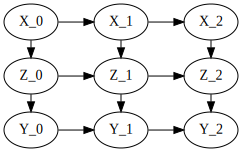

In [7]:
T = 3 # In this example, as in the paper, we consider three time-slices
init_sem, sem, dag_view, dag, exploration_sets, intervention_domain, true_objective_values  = setup_stat_scm(T=3)
dag_view

The above DAG is the graphical structure we will be working with and is faithful to the one used in figure one in the paper. `dag` is a networkx object i.e.

In [17]:
type(dag)

networkx.classes.multidigraph.MultiDiGraph

and is the one we will use for exploring the optimization methods further down. `dag_view` is simply a convenient way to visualise the structure at hand and is just a string that we visulise using `pygraphviz`:

In [18]:
print(dag_view)

digraph { rankdir=LR; X_0 -> Z_0; Z_0 -> Y_0; X_1 -> Z_1; Z_1 -> Y_1; X_2 -> Z_2; Z_2 -> Y_2;  X_0 -> X_1; Z_0 -> Z_1; Y_0 -> Y_1; X_1 -> X_2; Z_1 -> Z_2; Y_1 -> Y_2;  { rank=same; X_0 Z_0 Y_0 } { rank=same; X_1 Z_1 Y_1 } { rank=same; X_2 Z_2 Y_2 }  }


Notice that we make use of two types of structural equations models: `init_sem` and `sem`. The latter concerns interactions with the first time-slice in the DBN, which has no incoming edges from the previous time-slices, and is only active at $t=0$. For all other time-slices i.e. when $t>0$ the `sem` model is used.

In [10]:
# Number of independent samples (samples here are the time-series on the horizontal) per time-index
D_Obs = sequentially_sample_model(init_sem,
                                sem,
                                total_timesteps=T,
                                sample_count=5, # How many samples we take per node in each time-slice
                                epsilon=None) # If we employ a noise model or not

D_Obs

{'X': array([[ 1.76405235,  2.16420955,  3.14294754],
        [ 0.4105985 ,  0.55464207,  2.00891558],
        [ 0.3130677 , -0.54102804, -3.09401785],
        [-0.18718385,  1.34559536,  2.81495413],
        [ 1.23029068,  2.43267053,  2.04534371]]),
 'Z': array([[ 2.41224229e+00,  4.39464095e+00,  3.46051848e+00],
        [ 1.42429090e+00,  2.12024369e+00,  2.69824097e+00],
        [ 1.38481900e+00,  3.96702709e+00,  2.52904184e+01],
        [ 1.36079639e+00,  1.99934354e+00,  1.17146526e+00],
        [-1.00951244e-02, -9.70846048e-01, -2.26152826e+00]]),
 'Y': array([[-0.68189676, -1.94841594, -3.84232337],
        [-0.45160585, -0.37915648, -2.36142647],
        [ 1.52155989, -1.43112523, -0.68014656],
        [-2.7065599 , -4.374889  , -4.77284705],
        [-1.70682603, -0.24118898, -2.50766016]])}

The above observation samples contained in `D_obs` are sequential in the sense that the sample function generates each column per variable, conditional on the column samples at $t-1$.

## Other setup parameters 

In [8]:
# Contains the exploration sets we will be investigating
print(exploration_sets)
# The intervention domains for the manipulative variables
print(intervention_domain) 
# The true outcome values of Y given an optimal intervention on the three time-slices
print(true_objective_values)
# Number of trials
N = 10

[('X',), ('Z',), ('X', 'Z')]
{'X': [-4, 1], 'Z': [-3, 3]}
[-2.1518267393287287, -4.303653478657457, -6.455480217986186]


## Explore optimization methods

In all these examples we do not employ any interventional data, just observational.

### Vanilla Bayesian Optimization 

In [11]:
# Setup the input parameters to be used with the Bayesian optimization
BO_input_params = {
    "graph": dag,
    "sem": StationaryDependentSEM,
    "observational_samples": D_Obs,
    "intervention_domain": intervention_domain,
    "interventional_samples":None,   
    "number_of_trials": N,
    "optimal_assigned_blankets": None,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    "change_points": None
}

In [12]:
# Run Bayesian optimization
bo = BO(**BO_input_params)
bo.run_optimization()

Time index:  33%|███▎      | 1/3 [00:00<00:00,  4.85it/s]reconstraining parameters GP_regression.rbf.variance


Time: 0
Optimization restart 1/1, f = 4.143006475028315
Optimization restart 1/1, f = 4.434249159697096
Optimization restart 1/1, f = 5.577456306806231
Optimization restart 1/1, f = 6.311967728739278
Optimization restart 1/1, f = 8.46191778185456
Optimization restart 1/1, f = 8.226112269470772
Optimization restart 1/1, f = 8.335995430339224
Optimization restart 1/1, f = 7.850581043249649
Optimization restart 1/1, f = 6.181457170192694
Time: 1


Time index:  67%|██████▋   | 2/3 [00:00<00:00,  4.49it/s]reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 2.9946539384950763
Optimization restart 1/1, f = 6.134175859377086
Optimization restart 1/1, f = 10.567441329581792
Optimization restart 1/1, f = 11.88775947029168
Optimization restart 1/1, f = 13.226613664939904
Optimization restart 1/1, f = 16.210552115805246
Optimization restart 1/1, f = 15.911447362525013
Optimization restart 1/1, f = 15.92806164841201
Optimization restart 1/1, f = 15.14834856574356
Time: 2
Optimization restart 1/1, f = 7.649377033978306
Optimization restart 1/1, f = 8.70684551258357
Optimization restart 1/1, f = 7.5592662526228835
Optimization restart 1/1, f = 6.1093056130409495
Optimization restart 1/1, f = 13.419054002033736


Time index: 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

Optimization restart 1/1, f = 14.046107758809118
Optimization restart 1/1, f = 12.919428835380973
Optimization restart 1/1, f = 16.348118906500428
Optimization restart 1/1, f = 17.11180857679513


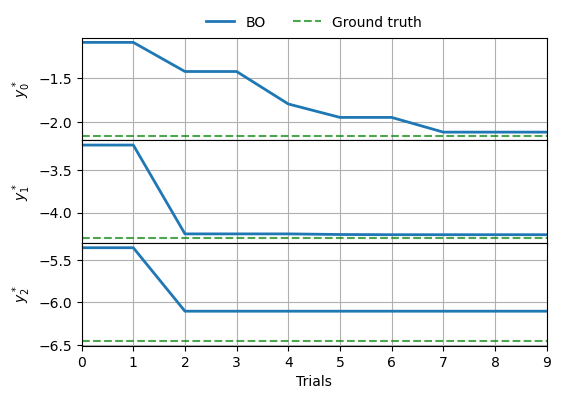

In [17]:
plot_outcome(T,N,outcomes=[bo.optimal_outcome_values_during_trials],labels=['BO'],true_objective_values=true_objective_values)

### Adaptive Bayesian Optimization
The setup for ABO is the same as for BO.

In [25]:
abo = ABO(**BO_input_params)
abo.run_optimization()

Time index:  33%|███▎      | 1/3 [00:00<00:00,  4.65it/s]reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 4.143006475028315
Optimization restart 1/1, f = 4.434249159697096
Optimization restart 1/1, f = 5.577456306806231
Optimization restart 1/1, f = 6.311967728739278
Optimization restart 1/1, f = 8.46191778185456
Optimization restart 1/1, f = 8.226112269470772
Optimization restart 1/1, f = 8.335995430339224
Optimization restart 1/1, f = 7.850581043249649
Optimization restart 1/1, f = 6.181457170192694
Optimization restart 1/1, f = 12.865012668719162
Optimization restart 1/1, f = 11.819638265536728

Time index:  67%|██████▋   | 2/3 [00:00<00:00,  4.29it/s]reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 9.801206720930248
Optimization restart 1/1, f = 7.556557869179121
Optimization restart 1/1, f = 12.949807878821627
Optimization restart 1/1, f = 13.620928998422164
Optimization restart 1/1, f = 15.63052374392776
Optimization restart 1/1, f = 14.225398702578584
Optimization restart 1/1, f = 16.811054246800353
Optimization restart 1/1, f = 18.26688443632344


Time index: 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]

Optimization restart 1/1, f = 17.916404093274693
Optimization restart 1/1, f = 17.73580226365098
Optimization restart 1/1, f = 16.178511288518038
Optimization restart 1/1, f = 13.80439173868917
Optimization restart 1/1, f = 12.69880999555464
Optimization restart 1/1, f = 10.65740656340628
Optimization restart 1/1, f = 11.404585357615092
Optimization restart 1/1, f = 11.312718293992738


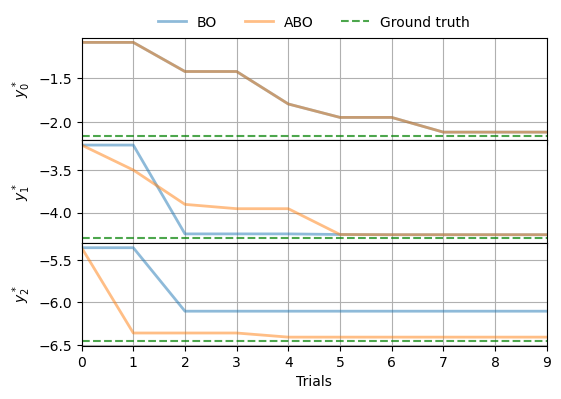

In [26]:
plot_outcome(T,N,outcomes=[bo.optimal_outcome_values_during_trials,abo.optimal_outcome_values_during_trials],labels=['BO', 'ABO'],true_objective_values=true_objective_values)

### Causal Bayesian Optimization
CBO has three extra parameters (though there are many others which we are not demonstrating in this demo) which is the SEM estimator method `auto_sem_dependent_stationary_hat`, the list of exploration sets (inferred by the BO and ABO previously). The final extra parameter is an indicator `root_instrument` which tells the method how to interpret the each time-slice in the DBN - with dependence on the past or not. If the argument is turned on that means that we are treating the first node in the time-slice (causal order assumed) as an instrument variable which is influenced only by the exogeneous model in the SCM.

In [64]:
CBO_input_params = {
    "graph": dag,
    "sem": StationaryDependentSEM,
    "make_sem_hat": auto_sem_dependent_stationary_hat,
    "exploration_sets":exploration_sets,
    "observational_samples": D_Obs,
    "intervention_domain": intervention_domain,
    "interventional_samples":None,
    "number_of_trials": N,
    "optimal_assigned_blankets": None,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    "change_points": None,
    "root_instrument":True
}

In [69]:
cbo = CBO(**CBO_input_params)
cbo.run_optimization()

Time index:   0%|          | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Time index:  33%|███▎      | 1/3 [00:04<00:09,  4.82s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.va

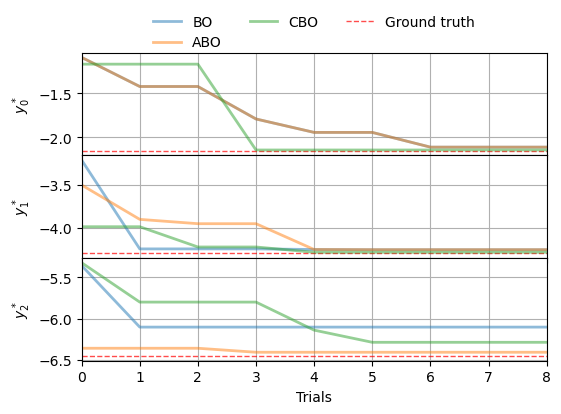

In [70]:
plot_outcome(T,N,outcomes=[bo.optimal_outcome_values_during_trials, abo.optimal_outcome_values_during_trials, cbo.optimal_outcome_values_during_trials],labels=['BO', 'ABO', 'CBO'],true_objective_values=true_objective_values)